In [1]:
import os
import sys

import jax
from neuron import h, gui

import braincell
from Golgi2020_morpho_1 import Golgi_morpho_1
from utils import *

## load gol mod
current_dir = os.getcwd()
mod_path = os.path.join(current_dir, 'mod_gol')
os.system(f'nrnivmodl {mod_path}')

current_dir = os.path.dirname(os.path.abspath('.'))
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))
dendritex_path = os.path.join(project_root, 'braincell')
sys.path.insert(0, dendritex_path)

brainstate.environ.set(precision=64)
#jax.config.update("jax_disable_jit", True)

# set visible GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
devices = jax.devices()

--No graphics will be displayed.
/home/swl/anaconda3/envs/braincell/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/home/swl/braincell/examples/MC13_golgi_model
Mod files: "/home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol/Cav12.mod" "/home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol/Cav13.mod" "/home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol/Cav2_3.mod" "/home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol/Cav3_1.mod" "/home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol/cdp5StCmod.mod" "/home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/MC13_golgi_model/golgi_NEURON/mod_gol/GOLGI_Ampa_mossy_det_vi.mod" "/home/swl/braincell/examples/MC13_golgi_m

## NEURON


5389 lines read
!!!!!!! Import3d_Section[0]
0: (-24.140000, 11.000000, 0.000000)
1: (-22.770000, 12.060000, 0.000000)
2: (-21.020000, 13.340000, 0.000000)
3: (-19.350000, 14.690000, 0.000000)
4: (-16.790000, 15.950000, 0.000000)
5: (-14.900000, 17.070000, 0.000000)
6: (-14.830000, 17.070000, 0.000000)
7: (-13.990000, 17.710000, 0.000000)
8: (-13.770000, 17.770000, 0.000000)
9: (-12.880000, 17.750000, 0.000000)
10: (-12.810000, 17.670000, 0.000000)
11: (-11.220000, 16.280000, 0.000000)
12: (-9.950000, 14.460000, 0.000000)
13: (-9.800000, 14.390000, 0.000000)
14: (-8.880000, 13.020000, 0.000000)
15: (-8.880000, 12.950000, 0.000000)
16: (-8.650000, 11.090000, 0.000000)
17: (-8.650000, 10.860000, 0.000000)
18: (-9.620000, 8.380000, 0.000000)
19: (-9.700000, 8.300000, 0.000000)
20: (-10.950000, 6.340000, 0.000000)
21: (-11.100000, 6.200000, 0.000000)
22: (-13.300000, 4.570000, 0.000000)
23: (-13.380000, 4.420000, 0.000000)
24: (-14.460000, 3.120000, 0.000000)
25: (-14.620000, 2.910000, 0.0

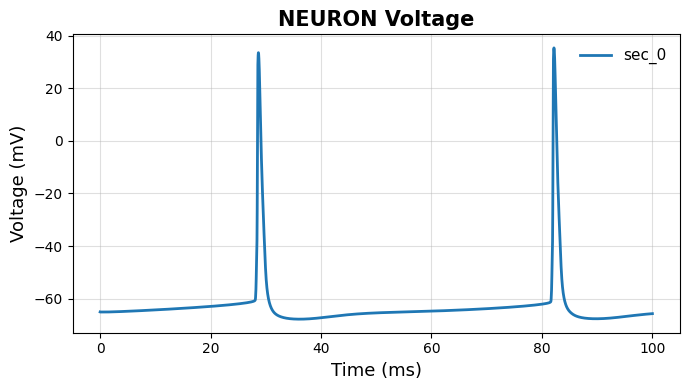

In [2]:
## create cell in NEURON
cell_neuron = Golgi_morpho_1(el=-55, gl=1, ghcn1=1, ghcn2=1, ena=60, gna=1, ek=-80, gkv11=1, gkv34=1, gkv43=1)

## add stim
stim = step_stim(cell_neuron, delay=0, dur=100, amp=0.0)

## simulation
t_neuron, v_neuron, spike_neuron = NeuronRun(cell=cell_neuron, stim=stim, tstop=100, dt=0.01, v_init=-65)

## plot voltage traces
plot_voltage_traces(t_neuron, v_neuron, indices=[0], title='NEURON Voltage')

## Braincell

In [3]:
class Golgi(braincell.MultiCompartment):
    def __init__(self, popsize, morphology, el, gl, gh1, gh2, ek, gkv11, gkv34, gkv43, ena, gnarsg, gcagrc=0, gcav23=0,
                 gcav31=0, gkca31=0, Gl=0, El=-65, V_init=-65, solver='exp_euler'):
        super().__init__(
            popsize=popsize,
            morphology=morphology,
            V_th=20. * u.mV,
            V_initializer=brainstate.init.Constant(V_init * u.mV),
            spk_fun=brainstate.surrogate.ReluGrad(),
            solver=solver, )

        self.IL = braincell.channel.IL(self.varshape, E=el * u.mV, g_max=gl * u.mS / (u.cm ** 2))
        self.Ih1 = braincell.channel.Ih1_Ma2020(self.varshape, E=-20. * u.mV, g_max=gh1 * u.mS / (u.cm ** 2))
        self.Ih2 = braincell.channel.Ih2_Ma2020(self.varshape, E=-20. * u.mV, g_max=gh2 * u.mS / (u.cm ** 2))

        self.k = braincell.ion.PotassiumFixed(self.varshape, E=ek * u.mV)
        self.k.add(IKv11=braincell.channel.IKv11_Ak2007(self.varshape, g_max=gkv11 * u.mS / (u.cm ** 2)))
        self.k.add(IKv34=braincell.channel.IKv34_Ma2020(self.varshape, g_max=gkv34 * u.mS / (u.cm ** 2)))
        self.k.add(IKv43=braincell.channel.IKv43_Ma2020(self.varshape, g_max=gkv43 * u.mS / (u.cm ** 2)))

        self.na = braincell.ion.SodiumFixed(self.varshape, E=ena * u.mV)
        self.na.add(INa_Rsg=braincell.channel.INa_Rsg(self.varshape, g_max=gnarsg * u.mS / (u.cm ** 2)))
        #self.na.add(INa =braincell.channel.INa_HH1952(self.varshape))

        #self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        #self.ca = braincell.ion.CalciumFixed(self.varshape, E=137.* u.mV, C =5e-5 * u.mM)
        #self.ca.add(ICaL=braincell.channel.ICaGrc_Ma2020(self.varshape, g_max=gcagrc * (u.mS / u.cm ** 2)))
        #self.ca.add(ICaL=braincell.channel.ICav23_Ma2020(self.varshape, g_max=gcav23 * (u.mS / u.cm ** 2)))
        #self.ca.add(ICaL=braincell.channel.ICav31_Ma2020(self.varshape, g_max=gcav31 * (u.mS / u.cm ** 2)))

        #self.kca = braincell.MixIons(self.k, self.ca)
        #self.kca.add(IKca = braincell.channel.IKca1_1_Ma2020(self.varshape, g_max=gkca31 * u.mS / (u.cm ** 2)))

    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value

In [ ]:
## create cell in Braincell
# 1.load morphology from asc file
Golgi_mor = braincell.Morphology.from_asc('pair-140514-C2-1_split_1.asc')

# 2.set sections' passive params: nseg, Ra and cm
sec_passive_params(Golgi_mor)

# 3.init dhs solver
Golgi_mor.dhs_init(plot=True)

# 4.set segments' active params: ion channel conductance, ion reversal potential and so on
gl, gh1, gh2, gkv11, gkv34, gkv43, gnarsg, gcagrc, gcav23, gcav31, gkca31 = seg_ion_params(Golgi_mor)
nseg = len(Golgi_mor.segments);
El = -55;
Ek = -80;
Ena = 60;
V_init = -65 * np.ones(nseg)

# 5.create Multicompartment model with morpho and ion channels
cell_braincell = Golgi(
    popsize=1, morphology=Golgi_mor,
    el=El, gl=gl, gh1=gh1, gh2=gh2, ek=Ek,
    gkv11=gkv11, gkv34=gkv34,
    gkv43=gkv43, ena=Ena, gnarsg=gnarsg,
    V_init=V_init, solver='staggered'
)

In [ ]:
# stim
DT = 0.01
I = step_input(num=nseg, dur=[100, 0, 0], amp=[0, 0, 0], dt=DT)

# simulation
t_braincell, v_braincell = BraincellRun(cell=cell_braincell, I=I, dt=DT)

# plot 
plot_voltage_comparison(
    t_neuron,
    v_neuron,
    t_braincell,
    v_braincell,
    indices=range(1)
)
